# AutoEncoder
- used for generative sampling

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import time

In [3]:
def get_mnist(file,limit=None):
    df = pd.read_csv('datasets/mnist_train_kaggle.csv')
    data = df.values
    # np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    X, Y = shuffle(X, Y)
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

In [28]:
class Autoencoder:
    def __init__(self, D, M):
        """
            Descr: initializes the layers, optimizer, and session
            params:
                D: input dimension
                M: hidden layer dimension
        """
        # batch of training data
        self.X = tf.placeholder(tf.float32, shape=(None, D))
        
        # input (D) to hidden (M)
        self.w = tf.Variable(tf.random_normal(shape=(D,M)) * 2 / np.sqrt(M))
        self.b = tf.Variable(np.zeros(M).astype(np.float32))
        
        # hidden (M) to output (D)
        self.v = tf.Variable(tf.random_normal(shape=(M,D)) * 2/ np.sqrt(D))
        self.c = tf.Variable(np.zeros(D).astype(np.float32))
        
        # reconstruction
        self.z = tf.nn.relu(tf.matmul(self.X, self.w) + self.b)
        logits = tf.matmul(self.z, self.v) + self.c
        self.X_hat = tf.nn.sigmoid(logits)
        
        # cost
        self.cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=logits))
        
        # optimizer
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=.001).minimize(self.cost)
        
        # set up session
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)
        
    def fit(self, X, epochs=30, batch_size=64, verbose=False):
        costs = []
        n_batches = len(X) // batch_size
        print("number of batches: " + str(n_batches))
        for i in range(epochs):
            if(verbose):
                print("epoch: " + str(i))
            np.random.shuffle(X)
            for j in range(n_batches):
                start = j * batch_size
                stop  = (j+1) * batch_size
                batch = X[start:stop]
                _, c, = self.sess.run((self.train_op, self.cost), feed_dict={self.X: batch})
                c /= batch_size
                costs.append(c)
                if(verbose):
                    if(j % 100 == 0):
                        print("iteration: %d, cost: %.3f" % (j,c))
        return costs
    
    def predict(self, X):
        return self.sess.run(self.X_hat, feed_dict={self.X: X})
        

In [30]:
X,y = get_mnist('datasets\mnist_train_kaggle.csv')
start = time.time()
with tf.device('/gpu:1'):
    model = Autoencoder(784, 300)
    costs = model.fit(X)
end = time.time()
print("total time: " + str(end-start))

number of batches: 656
total time: 23.53272557258606


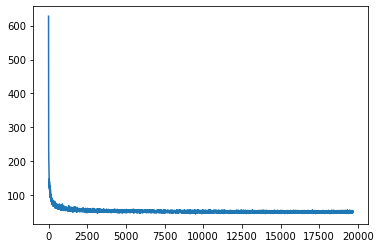

In [31]:
plt.plot(costs)
plt.show()

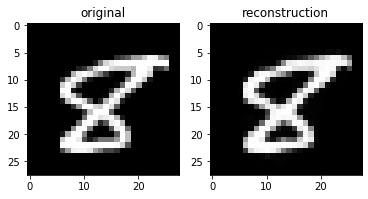

generate another? y


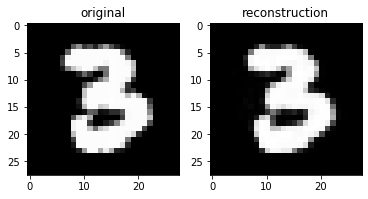

generate another? y


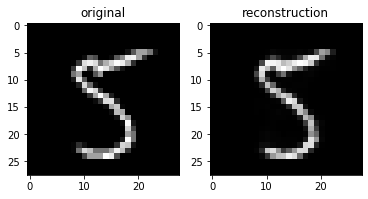

generate another? N


In [33]:
while(True):
    i = np.random.choice(len(X))
    x = X[i]
    img = model.predict([x]).reshape(28,28)
    plt.subplot(121)
    plt.imshow(x.reshape(28,28), cmap='gray')
    plt.title("original")
    plt.subplot(122)
    plt.imshow(img, cmap='gray')
    plt.title("reconstruction")
    plt.show()
    
    if(input("generate another?") in 'N'):
        break

In [34]:
model.sess.close()